In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
def get_xes_pumped(filename, DIR, DIRBS, roi, channel, ynstamp):
    numstds = 2.5
    minIzero = 0.01
    lin_filter = 0.2
    image_threshold = 2
    hot_pixel = 6

    print(DIR + filename + ".JF02T09V02crop.h5")
    print()
    print(DIRBS + filename + ".BSREAD.h5")
    
    images_off, images_on, pulse_ids_off, pulse_ids_on = \
        load_JF_cropped_data_pump(DIR + filename + ".JF02T09V02crop.h5", roi, 50, 50/2, nshots=None)
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, JFIDs_pump, JFIDs_unpump, Energy_pump, Energy_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_BS_pulse_ids, channel)
    (_, _, _, _, _, _, Laser_pump, Laser_unpump, _, _) = \
        load_PumpProbe_events_withTwoVariables(DIRBS + filename + ".BSREAD.h5", channel_PIPS_fluo, channel)
    
    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.mean(Energy_pump)
    
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.mean(Energy_unpump)
    
    idcheck = [a==b and c==d for a,b,c,d in zip(pulse_ids_on, JFIDs_pump, pulse_ids_off, JFIDs_unpump)]
    IDCheck = sum([int(x) for x in idcheck])
    
    if IDCheck:
        print("passed ID check")
    else:
        print("failed ID check")   
    
    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
#     print('numon')
#     print(IzeroFEL_pump.shape[0])
    
#     print('numoff')
#     print(IzeroFEL_unpump.shape[0])
    
    print('number of frames')
    print(images_on.shape[0])
    print(images_off.shape[0])

    images_good_on = images_on
    images_good_off = images_off

    images_thr_on = images_good_on.copy()
    images_thr_on[images_good_on < image_threshold] = 0
    images_thr_on[images_good_on > hot_pixel] = 0
    images_thr_on[np.isnan(images_thr_on)] = 0
    
    images_thr_off = images_good_off.copy()
    images_thr_off[images_good_off < image_threshold] = 0
    images_thr_off[images_good_off > hot_pixel] = 0
    images_thr_off[np.isnan(images_thr_off)] = 0
    
#     print('num nan')
#     print(sum(sum(sum(np.isnan(images_thr_on)))))
    
#     print('Izero')
#     print(np.mean(IzeroFEL_unpump))
#     print(np.mean(IzeroFEL_pump))
#     print(np.max(IzeroFEL_unpump))
#     print(np.min(IzeroFEL_unpump))
    
    IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump = \
        filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)
    

    
#     print(images_thr_on.shape)
#     print(images_thr_on.shape)
    
    images_thr_on = images_thr_on[condFinalPump]
    images_thr_off = images_thr_off[condFinalUnPump]

#     print('number of surviving frames')
#     print(images_thr_on.shape[0])
#     print(images_thr_off.shape[0])
    
    XES_on = images_thr_on.sum(axis=0)/images_thr_on.shape[0]
    XES_off = images_thr_off.sum(axis=0)/images_thr_off.shape[0]
    
    XES_on[np.isnan(XES_on)] = 0
    XES_off[np.isnan(XES_off)] = 0
    
#     print('num nan')
#     print(sum(sum(np.isnan(XES_on))))
    
    stamp = make_bar_stamp(XES_on.shape[1],XES_on.shape[0])
    
#     print(XES_on.shape)
#     print(stamp.shape)
    if ynstamp:

        XES_on = XES_on * stamp
        XES_off = XES_off * stamp
        
    FloFEL_pump_total = np.mean(DataFluo_pump)/np.mean(IzeroFEL_pump)
    FloFEL_unpump_total = np.mean(DataFluo_unpump)/np.mean(IzeroFEL_unpump)
    
    return XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, FloFEL_pump_total, FloFEL_unpump_total


In [4]:
def make_bar_stamp(dimension_x, dimension_y):

    X,Y = np.meshgrid(np.linspace(0,dimension_x-1,dimension_x),np.linspace(0,dimension_y-1,dimension_y))

    Z = np.zeros([dimension_y,dimension_x])+1

#     condition = np.logical_and(Y<260, Y>253)
#     Z[condition] = 0
    
#     Z[Y>320] = 0
#     Z[Y>284] = 0

# #     Z[Y < 200] = 0
#     Z[Y < 263] = 0

# #     condition = np.logical_not(np.logical_and(X<230, X>130))
#     condition = np.logical_not(np.logical_and(X<2300, X>92))
#     Z[condition] = 0

#     plt.figure()
#     plt.imshow(Z)
    
#     plt.colorbar()
    
    return Z

In [5]:
ynCompare12 = 'no'
#normalize = False

# folder_name_01 = 'XES_2836.5eV_600fs'
# folder_name_01 = 'XES_2842.0eV_10ps'

# # folder_name_01 = 'XES_2836.5eV_600fs'
# folder_name_01 = 'XES_2842.0eV_10ps'
folder_name_01 = 'XES_2842pink_Lbeta2_10ps'


# run_list_01 = [481,482,483]
run_list_01 = np.linspace(924,938,938-924+1)
run_list_01 = [int(x) for x in run_list_01]

# folder_name_01 = 'XES_RuDimerCl_2842.0eV_600fs'


# run_list_01 = np.linspace(501,540,40)
# fun_list_01 = [int(x) for x in run_list_01]

# folder_name_02 = 'XES_2836.5eV_10ps'
# folder_name_02 = 'XES_2842.0eV_600fs'

folder_name_02 = 'XES_RuDimerCl_2842.0eV_10ps'
# run_list_02 = [441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460]

# run_list_02 = [461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480]

run_list_02 = np.linspace(924,942,942-924+1)
fun_list_02 = [int(x) for x in run_list_01]

folder_name = folder_name_01
run_list = run_list_01

filename_base = "run_"

DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"



iterCounter = 0

for ii in run_list:


    XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
        get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 4, channel_energy, True)

    
        
    if False:

        plt.figure()
        plt.subplot(1,2,1)
        plt.title('ON')
        plt.imshow(XES_on, vmax = 0.001)
        plt.colorbar()
        plt.subplot(1,2,2)
        plt.title('OFF')
        plt.imshow(XES_off, vmax = 0.001)
        plt.colorbar()
        plt.tight_layout()

    
    if iterCounter == 0:
        rixs_on = XES_on
        rixs_off = XES_off
    else:
#             rixs_on = np.vstack(rixs_on,XES_on)
        rixs_on = rixs_on +XES_on
        rixs_off = rixs_off +XES_off

        print(rixs_on.shape)
    
    iterCounter +=1

    
xAxis = np.linspace(1,XES_on.shape[1],XES_on.shape[1])
 
# if len(run_list) == 1:
#     RIXS_on_01 = rixs_on
#     RIXS_off_01 = rixs_off
# else:
#     RIXS_on_01 = rixs_on.sum(axis=0)
#     RIXS_off_01 = rixs_off.sum(axis=0)
    
# err_on_01 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
# err_off_01 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)

/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000924.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000924.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000925.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000925.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000926.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000926.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000927.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw

/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in true_divide
/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: invalid value encountered in true_divide
/sf/alvra/anaconda/dev/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/sf/alvra/anaconda/dev/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000935.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000935.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000936.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000936.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000937.JF02T09V02crop.h5

/sf/alvra/data/p17983/raw/XES_2842pink_Lbeta2_10ps/run_000937.BSREAD.h5
images_roi4
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
SLAAR11-LMOT-M451:ENC_1_BS/pulse_id
passed ID check
number of frames
1250
1250
(512, 200)
/das/work/p17/p17983/cropped_data/XES_2842pink_Lbeta2_10ps/run_000938.JF02T09V02crop.h5

/sf

<IPython.core.display.Javascript object>


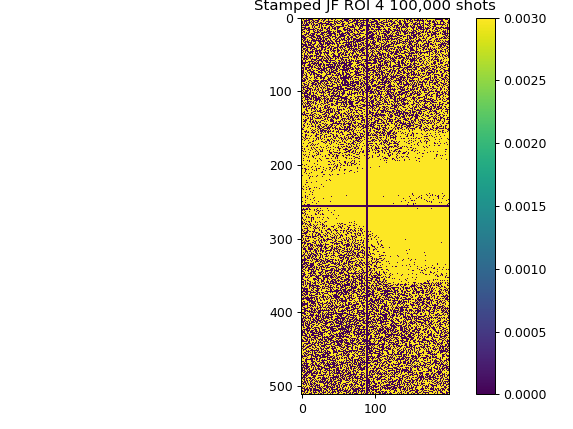

(512, 200)


<IPython.core.display.Javascript object>


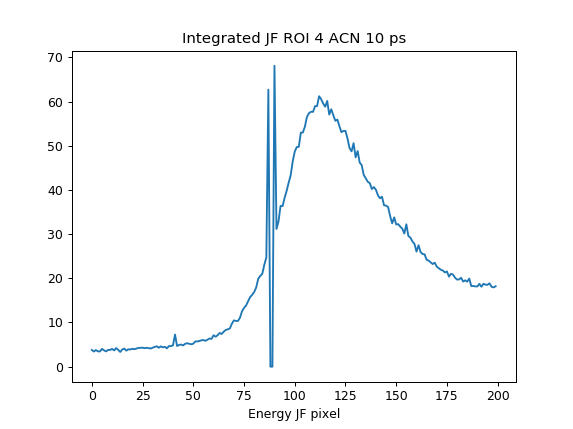

Text(0.5, 0, 'Energy JF pixel')

In [6]:
rixs = rixs_off+rixs_on
plt.figure()
# plt.plot(rix_on+rix_off)
plt.imshow(rixs, vmax = 0.003)
plt.colorbar()  
plt.tight_layout()
plt.title('Stamped JF ROI 4 100,000 shots')

rixs_sum = rixs.sum(axis = 0)
print(rixs.shape)
plt.figure()
plt.plot(rixs_sum)

plt.title('Integrated JF ROI 4 ACN 10 ps')
plt.xlabel('Energy JF pixel')





(200,)


/sf/alvra/anaconda/dev/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


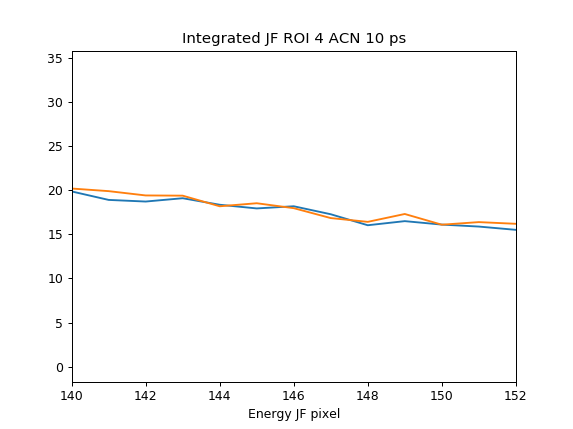

<IPython.core.display.Javascript object>


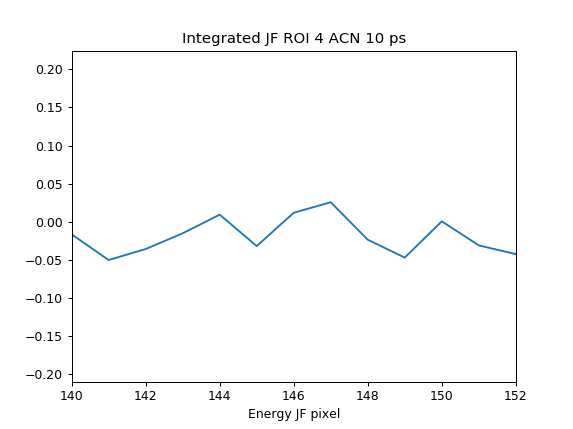

(140, 152)

In [7]:
rixs_sum_on = rixs_on.sum(axis = 0)
rixs_sum_off = rixs_off.sum(axis = 0)







rixs_trans = (rixs_sum_on-rixs_sum_off)/rixs_sum_off



print(rixs_trans.shape)







plt.figure()
plt.plot(rixs_sum_on)
plt.plot(rixs_sum_off)
plt.title('Integrated JF ROI 4 ACN 10 ps')
plt.xlabel('Energy JF pixel')
plt.xlim([140,152])





# print(rixs.shape)
plt.figure()
plt.plot(rixs_trans)
plt.title('Integrated JF ROI 4 ACN 10 ps')
plt.xlabel('Energy JF pixel')
plt.xlim([140,152])

In [8]:
# if ynCompare12 == 'yes':

#     folder_name = folder_name_02
#     run_list = run_list_02
#     DIR = "/das/work/p17/p17983/cropped_data/" + folder_name + "/"
#     DIRBS = "/sf/alvra/data/p17983/raw/" + folder_name + "/"

#     iterCounter = 0

#     for ii in run_list:

#         XES_on, XES_off, Energy_eV_pump, Energy_eV_unpump, fluo_pump, fluo_unpump = \
#             get_xes_pumped(filename_base + '%06d' % (ii), DIR, DIRBS, 2, channel_energy, True)

#         if False:

#             plt.figure()
#             plt.subplot(1,2,1)
#             plt.title('ON')
#             plt.imshow(XES_on, vmax = 0.001)
#             plt.colorbar()
#             plt.subplot(1,2,2)
#             plt.title('OFF')
#             plt.imshow(XES_off, vmax = 0.001)
#             plt.colorbar()
#             plt.tight_layout()


#         if iterCounter == 0:
#             rixs_on = XES_on
#             rixs_off = XES_off
#         else:
# #             rixs_on = np.vstack(rixs_on,XES_on)
#             rixs_on = rix_on +XES_on
#             rixs_on = rix_off +XES_off

#         print(rixs_on.shape)
# #             rixs_off = np.vstack(rixs_off,XES_off)

#         iterCounter +=1

# #     if len(run_list) == 1:
# #         RIXS_on_02 = rixs_on
# #         RIXS_off_02 = rixs_off
# #     else:
# #         RIXS_on_02 = rixs_on.sum(axis=0)
# #         RIXS_off_02 = rixs_off.sum(axis=0)
        
# #     err_on_02 = np.std(rixs_on, axis = 0)/np.sqrt(rixs_on.shape[0]-1)
# #     err_off_02 = np.std(rixs_off, axis = 0)/np.sqrt(rixs_off.shape[0]-1)
    

In [9]:
# normalize = False



# RIXS_trans_01 = (RIXS_on_01-RIXS_off_01)
# err_trans_01 = err_adder(err_on_01,err_off_01)
# if normalize:
#     RIXS_trans_01 = RIXS_trans_01/RIXS_off_01
#     err_trans_01 = RIXS_trans_01/RIXS_off_01*err_adder(err_trans_01/RIXS_trans_01,err_off_01/RIXS_off_01)

    
# xRange_01 = [140,220]

# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(xAxis,RIXS_trans_01)
# plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
# plt.xlabel('JF pixel')
# plt.ylabel('Intensity (arb)')
# plt.title('XES transient '+folder_name_01)
# # plt.xlim(xRange_01)

# plt.subplot(2,1,2)
# plt.plot(xAxis,RIXS_on_01, label ='XES ON')
# plt.fill_between(xAxis,RIXS_on_01+err_on_01,RIXS_on_01-err_on_01, alpha = 0.2)
# plt.plot(xAxis,RIXS_off_01, label = 'XES OFF')
# plt.fill_between(xAxis,RIXS_off_01+err_off_01,RIXS_off_01-err_off_01, alpha = 0.2)
# plt.xlabel('JF pixel')
# plt.ylabel('Intensity (arb)')
# plt.title('XES ' +folder_name_01)
# # plt.xlim(xRange_01)
# plt.legend()

# plt.tight_layout()


In [10]:
# if ynCompare12 == 'yes':
#     RIXS_trans_02 = (RIXS_on_02-RIXS_off_02)
#     err_trans_02 = err_adder(err_on_02,err_off_02)
#     if normalize:
#         RIXS_trans_02 = RIXS_trans_02/RIXS_off_02
#         err_trans_02 = RIXS_trans_02/RIXS_off_02*err_adder(err_trans_02/RIXS_trans_02,err_off_02/RIXS_off_02)


#     xRange_02 = xRange_01

#     plt.figure()
#     plt.subplot(2,1,1)
#     plt.plot(xAxis,RIXS_trans_02)
#     plt.fill_between(xAxis,RIXS_trans_02+err_trans_02,RIXS_trans_02-err_trans_02,alpha = 0.2)
#     plt.xlabel('JF pixel')
#     plt.ylabel('Intensity (arb)')
#     plt.title('XES transient '+folder_name_02)
#     plt.xlim(xRange_02)

#     plt.subplot(2,1,2)
#     plt.plot(xAxis,RIXS_on_02, label ='XES ON')
#     plt.fill_between(xAxis,RIXS_on_02+err_on_02,RIXS_on_02-err_on_02, alpha = 0.2)
#     plt.plot(xAxis,RIXS_off_02, label = 'XES OFF')
#     plt.fill_between(xAxis,RIXS_off_02+err_off_02,RIXS_off_02-err_off_02, alpha = 0.2)
#     plt.xlabel('JF pixel')
#     plt.ylabel('Intensity (arb)')
#     plt.title('XES ' +folder_name_02)
#     plt.xlim(xRange_02)
#     plt.legend()

#     plt.tight_layout()

In [11]:
# if ynCompare12 == 'yes':
#     scale_01 = len(run_list_01)
#     scale_02 = len(run_list_02)
    
#     plt.figure()
#     plt.plot(xAxis,RIXS_trans_01, label = folder_name_01)
#     plt.fill_between(xAxis,RIXS_trans_01+err_trans_01,RIXS_trans_01-err_trans_01,alpha = 0.2)
#     plt.plot(xAxis,RIXS_trans_02, label = folder_name_02)
#     plt.fill_between(xAxis,RIXS_trans_02+err_trans_02,RIXS_trans_02-err_trans_02,alpha = 0.2)
#     plt.xlabel('JF pixel')
#     plt.ylabel('Intensity (arb)')
#     plt.title('XES transient Comparison')
#     plt.legend()
#     plt.xlim(xRange_02)
    
    
#     plt.figure()
#     plt.plot(xAxis,RIXS_on_01/scale_01, label ='XES ON'+folder_name_01)
#     plt.fill_between(xAxis,(RIXS_on_01+err_on_01)/scale_01,(RIXS_on_01-err_on_01)/scale_01, alpha = 0.2)
#     plt.plot(xAxis,RIXS_on_02/scale_02, label ='XES ON'+folder_name_02)
#     plt.fill_between(xAxis,(RIXS_on_02+err_on_02)/scale_02,(RIXS_on_02-err_on_02)/scale_02, alpha = 0.2)
#     plt.xlabel('JF pixel')
#     plt.ylabel('Intensity (arb)')
#     plt.title('XES ON Comparison')
#     plt.legend()
#     plt.xlim(xRange_02)
    
#     plt.figure()
#     plt.plot(xAxis,RIXS_off_01/scale_01, label ='XES OFF'+folder_name_01)
#     plt.fill_between(xAxis,(RIXS_off_01+err_off_01)/scale_01,(RIXS_off_01-err_off_01)/scale_01, alpha = 0.2)
#     plt.plot(xAxis,RIXS_off_02/scale_02, label ='XES OFF'+folder_name_02)
#     plt.fill_between(xAxis,(RIXS_off_02+err_off_02)/scale_02,(RIXS_off_02-err_off_02)/scale_02, alpha = 0.2)
#     plt.xlabel('JF pixel')
#     plt.ylabel('Intensity (arb)')
#     plt.title('XES OFF Comparison')
#     plt.legend()
#     plt.xlim(xRange_02)

In [12]:
# if False:
#     red_data_file_01 = '/das/work/p17/p17983/Reduced_data/'+ folder_name_01

#     np.save(red_data_file_01+'XES_on',RIXS_on_01/scale_01)
#     np.save(red_data_file_01+'XES_on_err',err_on_01/scale_01)
    
#     np.save(red_data_file_01+'XES_off',RIXS_off_01/scale_01)
#     np.save(red_data_file_01+'XES_off_err',err_off_01/scale_01)
    
#     np.save(red_data_file_01+'XES_trans',RIXS_trans_01)
#     np.save(red_data_file_01+'XES_trans_err',err_trans_01)
    
# if False:
#     red_data_file_02 = '/das/work/p17/p17983/Reduced_data/'+ folder_name_02
    
#     np.save(red_data_file_02+'XES_on',RIXS_on_02/scale_02)
#     np.save(red_data_file_02+'XES_on_err',err_on_02/scale_02)
    
#     np.save(red_data_file_02+'XES_off',RIXS_off_02/scale_02)
#     np.save(red_data_file_02+'XES_off_err',err_off_02/scale_02)
    
#     np.save(red_data_file_02+'XES_trans',RIXS_trans_02/scale_02)
#     np.save(red_data_file_02+'XES_trans_err',err_trans_02/scale_02)
    
    

    
    
